In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import KFold


In [52]:
ds_dir = '../Datasets/5-classes'
img_height = 256
img_width = 256

In [53]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Train',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Train')),
    image_size=(img_height, img_width)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Val',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Val')),
    image_size=(img_height, img_width)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory=ds_dir + '/Test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=sum(len(files) for _, _, files in os.walk(ds_dir + '/Test')),
    image_size=(img_height, img_width)
)

Found 2020 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 1035 files belonging to 5 classes.


In [54]:
for x, y in train_ds:
    x_train = x.numpy()
    y_train = y.numpy()

for x, y in validation_ds:
    x_val = x.numpy()
    y_val = y.numpy()

for x, y in test_ds:
    x_test = x.numpy()
    y_test = y.numpy()

# x_train = np.concatenate((x_train, x_val), axis=0)
# y_train = np.concatenate((y_train, y_val), axis=0)


In [55]:
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [56]:
normalize = lambda ds: ds / 255 - 0.5

x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

In [57]:
flatten = lambda ds: ds.reshape((-1, ds.shape[1] ** 2))

print(x_train.shape)
print(x_test.shape)

x_train = flatten(x_train)
x_val = flatten(x_val)
x_test = flatten(x_test)

print(x_train.shape)
print(x_test.shape)

(2020, 256, 256, 1)
(1035, 256, 256, 1)
(2020, 65536)
(1035, 65536)


### Summary

In [58]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 32)                2097184   
                                                                 
 dense_75 (Dense)            (None, 8)                 264       
                                                                 
 dense_76 (Dense)            (None, 32)                288       
                                                                 
 dense_77 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,097,901
Trainable params: 2,097,901
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    x_train, y_train,
    batch_size=128,
    validation_split=0.33,
    epochs=20,
    verbose=1
)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
11/11 [==============================] - 2s 46ms/step - loss: 1.5461 - accuracy: 0.2993 - val_loss: 1.4898 - val_accuracy: 0.3208
Epoch 2/20
11/11 [==============================] - 0s 35ms/step - loss: 1.4504 - accuracy: 0.3422 - val_loss: 1.4451 - val_accuracy: 0.3388
Epoch 3/20
11/11 [==============================] - 0s 37ms/step - loss: 1.4013 - accuracy: 0.3511 - val_loss: 1.3913 - val_accuracy: 0.3238
Epoch 4/20
11/11 [==============================] - 0s 33ms/step - loss: 1.3608 - accuracy: 0.3444 - val_loss: 1.3642 - val_accuracy: 0.3688
Epoch 5/20
11/11 [==============================] - 0s 34ms/step - loss: 1.3157 - accuracy: 0.3954 - val_loss: 1.3089 - val_accuracy: 0.3823
Epoch 6/20
11/11 [==============================] - 0s 34ms/step - loss: 1.2707 - accuracy: 0.4302 - val_loss: 1.2799 - val_accuracy: 0.4603
Epoch 7/20
11/11 [==============================] - 0s 33ms/step - loss: 1.2352 - accuracy: 0.4878 - val_loss: 1.2392 - val_accuracy: 0.4858
Epoch 8/20
11

In [61]:
def generate_actual_predicted(model, X_test, Y_test):
    Y_pred = model.predict(X_test)

    predicted = []
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
    
    actual = []
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
    
    return actual, predicted

actual, predicted = generate_actual_predicted(model, x_test, y_test)

### Evaluation Metrics

In [62]:
print(confusion_matrix(actual,predicted))
print(accuracy_score(actual, predicted))

[[ 54   0   0  15 138]
 [ 48  85   8  11  55]
 [  3  19 165  14   6]
 [  5  35 110  51   6]
 [ 24   2   0   3 178]]
0.514975845410628


In [63]:
print(f1_score(actual, predicted, average='macro'))
print(precision_score(actual, predicted, average='macro'))
print(recall_score(actual, predicted, average='macro'))

0.4841901879611391
0.5192331946062689
0.514975845410628


In [64]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.40      0.26      0.32       207
           1       0.60      0.41      0.49       207
           2       0.58      0.80      0.67       207
           3       0.54      0.25      0.34       207
           4       0.46      0.86      0.60       207

    accuracy                           0.51      1035
   macro avg       0.52      0.51      0.48      1035
weighted avg       0.52      0.51      0.48      1035



### Accuracy Curve

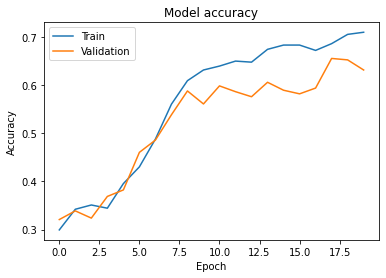

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Loss Curve

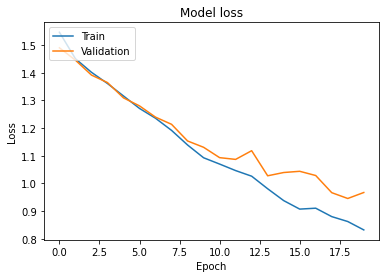

In [66]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

### K-Fold

In [67]:
def create_model():
    model = Sequential()
    model.add(Dense(8, input_dim=x_train.shape[1],activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model


In [68]:
n_folds=10

results = []


x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
# print(x_train_val.shape)
# print(y_train_val.shape)

# print(f'y_train_val is one-hot-encoded: {(y_train_val.sum(axis=1)-np.ones(y_train_val.shape[0])).sum()==0}')

In [69]:
for train_index, test_index in KFold(n_folds).split(x_train_val):
    x_tr, x_ts = x_train_val[train_index], x_train_val[test_index]
    y_tr, y_ts = y_train_val[train_index], y_train_val[test_index]
    
    model = create_model()
    model.fit(x_tr, y_tr, epochs=30, batch_size=128)
    
    scores = model.evaluate(x_test,y_test)

    for i,names in zip(np.arange(0, len(model.metrics_names)), model.metrics_names):
        print(model.metrics_names[i],'=',scores[i])

    actual, predicted = generate_actual_predicted(model, x_ts, y_ts)

    precision = precision_score(actual, predicted, average='macro')
    recall = recall_score(actual, predicted, average='macro')
    f1 = f1_score(actual, predicted, average='macro')

    print('precision', precision)
    print('recall', recall)
    print('F1-Score', f1)

    results.append([model, precision, recall, f1])

Epoch 1/30
18/18 [==============================] - 1s 18ms/step - loss: 1.4642 - accuracy: 0.3805
Epoch 2/30
18/18 [==============================] - 0s 17ms/step - loss: 1.3015 - accuracy: 0.4286
Epoch 3/30
18/18 [==============================] - 0s 18ms/step - loss: 1.2456 - accuracy: 0.4295
Epoch 4/30
18/18 [==============================] - 0s 18ms/step - loss: 1.2080 - accuracy: 0.4515
Epoch 5/30
18/18 [==============================] - 1s 20ms/step - loss: 1.1981 - accuracy: 0.4634
Epoch 6/30
18/18 [==============================] - 0s 18ms/step - loss: 1.1548 - accuracy: 0.4965
Epoch 7/30
18/18 [==============================] - 0s 19ms/step - loss: 1.1320 - accuracy: 0.5498
Epoch 8/30
18/18 [==============================] - 0s 19ms/step - loss: 1.0818 - accuracy: 0.5811
Epoch 9/30
18/18 [==============================] - 0s 20ms/step - loss: 1.0545 - accuracy: 0.5895
Epoch 10/30
18/18 [==============================] - 0s 19ms/step - loss: 1.0325 - accuracy: 0.5926
Epoch 11/

[0.6072953929539295 0.5971638136351649 0.5345147222019716
 0.593035420516108 0.6401155962537036 0.5517675282464015 0.602192228986654
 0.3952687063844303 0.5179675925082086 0.4297902979518865]
[0.6028956319369854 0.5285412295588059 0.5614205082642176
 0.5825434669514584 0.6326530612244898 0.5235423528433051
 0.6000365638995232 0.36690027121959895 0.4813633387888707
 0.42989508290451683]


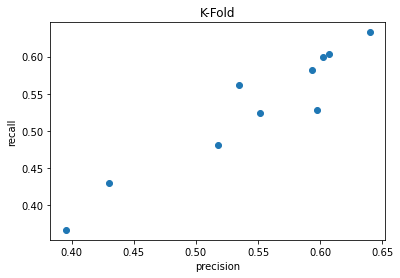

min precision: 0.3952687063844303
min recall: 0.36690027121959895
max precision: 0.6401155962537036
max recall: 0.6326530612244898
average precision: 0.5469111299638458 sd= 0.07600645490210509
average recall: 0.5309791507591772 sd= 0.07970375856919965


In [70]:
res = np.array(results)

prec = res[:,1]
print(prec)
recl = res[:,2]
print(recl)

plt.scatter(prec, recl)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('K-Fold') 
plt.show()

print('min precision:', prec.min())
print('min recall:', recl.min())
print('max precision:', prec.max())
print('max recall:', recl.max())
print('average precision:', prec.mean(), 'sd=', prec.std())
print('average recall:', recl.mean(),'sd=', recl.std())

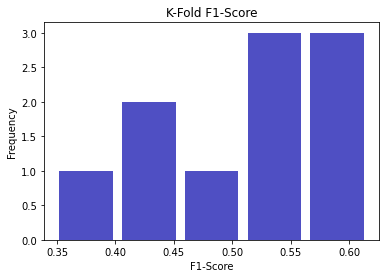

F1-Score: 0.5032326144782503 sd= 0.08849466425824952


In [71]:
res = np.array(results)
f1_score = res[:,3]
plt.hist(x=f1_score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('K-Fold F1-Score') 
plt.ylabel('Frequency') 
plt.xlabel('F1-Score') 
plt.show()
print('F1-Score:', f1_score.mean(), 'sd=', f1_score.std())

res_model1 = res

In [72]:
best_model = res[np.argmax(res[:,2]), 0]
best_model

In [73]:
best_model.evaluate(
    x_test,
    y_test
)

33/33 [==============================] - 0s 4ms/step - loss: 1.3974 - accuracy: 0.4570


[1.397397756576538, 0.4570048451423645]